# NCP Model
This script will oad the data compilation file (ship.data) and then setup and run the NCP model. Finally, it will produce graphs and plots based on NCP and the cycle/transect/stations.

In [6]:
source('source.r')
source('source.equations.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


In [7]:
#setwd('/Volumes/Repository/Dropbox/CCE-shipdata/MIMS-TBK/')
# Load the data
load(file='RStates/ship.final.2min.rdata')
#load(file='RStates/ship.final.30min.rdata')

## Verify the loaded data
ship.data = ship.data[!is.na(ship.data$LO), ]
ship.data = ship.data[!is.na(ship.data$Cycle), ]

In [8]:
# Method here refers to the method used to normalize, 1 = std, 2 = IQR

plot.timeseries = function(cycle = 'Cycle1', method = 2) {    
    if (cycle == 'all') {
        l = 1:nrow(ship.data)
    } else {
        l = which(ship.data$Cycle == cycle)
        l.op = which(ship.data$Cycle == cycle & ship.data$MIMS.O2.Ar.FLAG == 1)  ## Remove calibration cycling artefacts
    }
    
    plot(ship.data$DT[l], rep(0, nrow(ship.data[l,])), col = 'white', ylim=c(1, 12), main=cycle)

    ## EIMS 32
    text(ship.data$DT[l[1]] + 13000, 3, 'EIMS 32', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$EIMS.32[l] / ship.data$EIMS.32.cal[l], offset = 2,
                        scale = 0.3, col='dark green', method = method)
    
    ## Optode
    text(ship.data$DT[l[1]] + 13000, 11, 'Optode Ch2', cex=0.7)
    add.normalized.line(ship.data$DT[l.op], ship.data$Optode.ch2[l.op], offset = 10, scale = 0.6, col='blue',
                        method = method)
    
    ## Ship Data
    text(ship.data$DT[l[1]] + 13000, 7, 'Ship O2', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$OX[l], offset = 5, scale = 0.5, method = method)
    
    ## MIMS 32
    text(ship.data$DT[l[1]] + 13000, 9, 'MIMS 32', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$MIMS.32[l] / ship.data$MIMS.32.cal[l], offset = 8,
                        scale = 0.3, col='dark green', method = method)
    
    ## EIMS Optode
    text(ship.data$DT[l[1]] + 13000, 5, 'EIMS O2', cex=0.7)
    add.normalized.line(ship.data$DT[l], ship.data$EIMS.O2[l], offset = 4, scale = 0.3, col='blue', method = method)
}

In [ ]:
pdf('Output/NCP Module - Timeseries Review (Individual Oxygen).pdf')

par(mfrow=c(2,2))
for (i in unique(ship.data$Cycle)) {
    plot.timeseries(i)
}

dev.off()

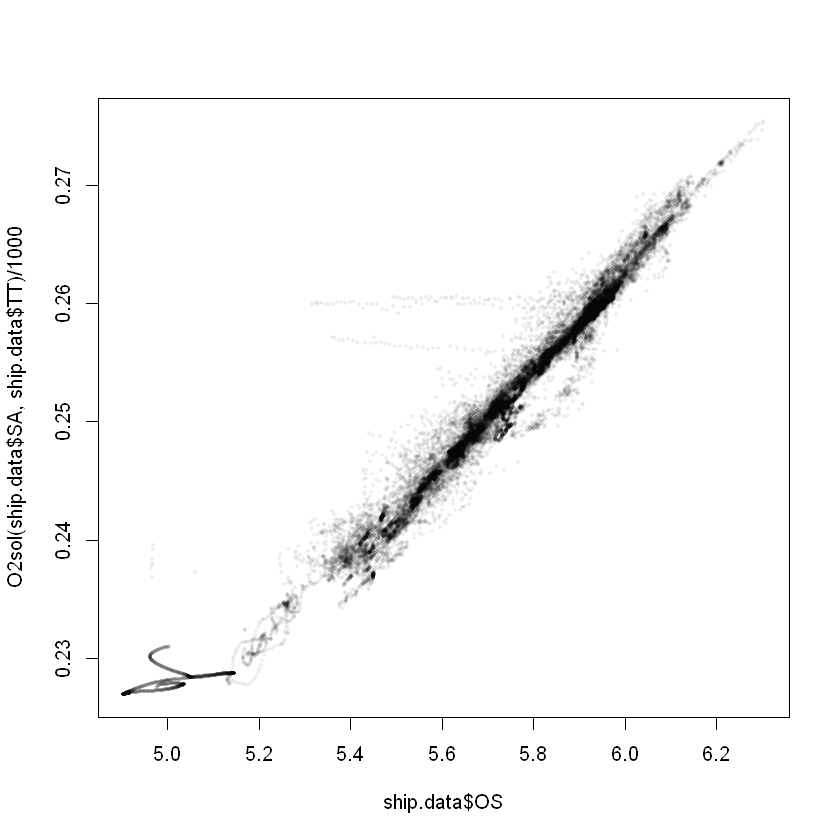

In [62]:
plot(ship.data$OS, O2sol(ship.data$SA, ship.data$TT)/1000, pch=16, cex=0.4, col='#00000010')

# NCP Calculation

In [9]:
# NCP in mmol O2 m-2 d-1; seawater density in kg m-3, O2sol in microL kg-1
#ncp = (ship.data$O2.Ar/100) * (O2sol(ship.data$SA, ship.data$TT) / 1000) * ship.data$sw_dens0(salt, temp) * wpv;

calc.ncp = function(o2ar, o2ar.cal, S, T, k) {
    ncp = (o2ar / o2ar.cal - 1) * O2sol(S, T) / 1000 * rho(S, T) * k
}

ship.data$BOS.EIMS = ship.data$EIMS.O2.Ar / ship.data$EIMS.O2.Ar.cal - 1
ship.data$NCP.EIMS = calc.ncp(ship.data$EIMS.O2.Ar, ship.data$EIMS.O2.Ar.cal, ship.data$SA,
                              ship.data$TT, ship.data$k)

ship.data$BOS.MIMS = ship.data$MIMS.O2.Ar / ship.data$MIMS.O2.Ar.cal - 1
ship.data$NCP.MIMS = calc.ncp(ship.data$MIMS.O2.Ar, ship.data$MIMS.O2.Ar.cal, ship.data$SA,
                              ship.data$TT, ship.data$k)

ship.data = ship.data[!is.na(ship.data$NCP.EIMS),]
ship.data = ship.data[!is.na(ship.data$NCP.MIMS),]
ship.data = ship.data[!is.na(ship.data$BOS.EIMS),]
ship.data = ship.data[!is.na(ship.data$BOS.MIMS),]

# Preliminary Review

In [10]:
pdf('Output/NCP Module - NCP Diagnostics.pdf')

par(mfrow=c(2,1))

################################
## O2 solubility and temperature
################################
plot(ship.data$DT, O2sol(ship.data$SA, ship.data$TT) / 1000, type='l', ylab='O2 Solubility',
     ylim=c(0.23, 0.30), xlab='', main='Solubility and Temperature')
#add.daynight()
lines(ship.data$DT, ship.data$TT/300 + 0.235, col='red', lwd=1)
legend(ship.data$DT[1], 0.30, c('Temp', 'Sol.'), col=c('red', 'black'), cex=0.6, lwd=2)

################################
## Biological O2 argon singal
################################
plot(ship.data$DT, ship.data$BOS.EIMS, pch=20, cex=0.1, ylab='Biological O2 Ar Signal (EIMS)', xlab='',
     main='Delta O2/Ar - EIMS', ylim=c(-0.35, 0.35))
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)


plot(ship.data$DT,  ship.data$BOS.MIMS, pch=20, cex=0.1, ylab='Biological O2 Ar Signal (MIMS)', xlab='',
     main='Delta O2/Ar - MIMS', ylim=c(-0.35, 0.35))
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)

################################
## Wind speed and k values
################################
plot(ship.data$DT, ship.data$k, type='l', ylab='Ventilation Rate', main='k Value', xlab='', yaxs='i', ylim=c(0,5))
#add.daynight()

plot(ship.data$DT, ship.data$NCEP, ylim=c(0, 50), pch=20, cex=0.1, xaxs='i', ylab='Wind Speed (MLD)',
     xlab='', main='NCEP Wind Speed (MLD in Orange)')
points(ship.data$DT, ship.data$MLD, col='orange', pch=20, cex=0.1)
#legend(ship.data$DT[1], 10, c('K', 'Wind'), col=c('black', 'red'), cex=0.6, lwd=2)

################################
## NCP plot (smoothed)
################################
plot(ship.data$DT, ma(ship.data$NCP.EIMS, 25), type='l', ylab='Smoothed EIMS NCP (mmol O2 m-1 d-1)',
     ylim=c(-100, 100), xlab='')
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)


plot(ship.data$DT, ma(ship.data$NCP.MIMS, 25), type='l', ylab='Smoothed MIMS NCP (mmol O2 m-1 d-1)',
     ylim=c(-100, 100), xlab='')
#add.daynight()
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0, 0), lty=2)


dev.off()

png 
  2

In [ ]:
par(mfrow=c(2,1))

plot(ship.data$DT,runmed(ship.data$MIMS.32.cal, 31), pch=20, cex=0.1, ylab='MIMS 32 cal',
     xlab='', col = get.qual.pal(5)[ship.data$MIMS.32.cal.FLAG])

plot(ship.data$DT,runmed(ship.data$EIMS.32.cal, 31), pch=20, cex=0.1, ylab='EIMS 32 cal',
     xlab='')

plot(ship.data$DT, runmed(ship.data$MIMS.32, 31) / runmed(ship.data$MIMS.32.cal, 31) - 1, pch=20, cex=0.1, ylab='MIMS 32 sat',
     xlab='', ylim=c(-.5,.5))
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0,0), lty=2, col='red')

plot(ship.data$DT, ship.data$EIMS.32 / ship.data$EIMS.32.cal - 1, pch=20, cex=0.1, ylab='EIMS 32 sat',
     xlab='', ylim=c(-0.5,0.5))
lines(c(min(ship.data$DT), max(ship.data$DT)), c(0,0), lty=2, col='red')

In [ ]:
plot(ship.data$DT, runmed(ship.data$BOS.EIMS, 821), pch=16, cex=0.2, ylim=c(-0.4,0.4), ylab='Biological Oxygen Signal',
     xlab='')

points(ship.data$DT, runmed(ship.data$BOS.MIMS, 811), pch=16, cex=0.2, col='red')
#points(ship.data$DT, runmed(ship.data$NCP.MIMS2, 2011), pch=16, cex=0.2, col='blue')
lines(c(ship.data$DT[1], max(ship.data$DT)), c(0,0), lty=2)

In [51]:
c(1:10) %% 4

[1] 1 2 3 0 1 2 3 0 1 2

In [86]:
plot.seasoar = function(cycle, instrument='MIMS', type='BOS', mark=NA) {
    l = which(ship.data$Cycle == cycle)
    
    if (instrument == 'MIMS') {
        col = make.div.pal2(runmed(ship.data$NCP.MIMS[l], 21), 10, min = -100, max = 100)
        col.bos = make.div.pal2(runmed(ship.data$BOS.MIMS[l], 21), 10, min = -0.2, max = 0.2)
    } else {
        col = make.div.pal2(runmed(ship.data$NCP.EIMS[l], 21), 10, min = -100, max = 100)
        col.bos = make.div.pal2(runmed(ship.data$BOS.EIMS[l], 21), 10, min = -0.2, max = 0.2)
    }
    
    if (type == 'NCP') {
        ## Plot NCP
        plot.map(ship.data$LO[l], ship.data$LA[l], col = col, zoom = 1.5, cex = 1.5)

        ## Legend
        points(x = rep(-120, 101), y = seq(35, 37, 1/50), col=get.div.pal(101), pch=16, cex=1.5)
        text(-119.7, 37.2, '100 mmol O2 m-2 d-1')
        text(-119.7, 34.8, '-100 mmol O2 m-2 d-1')
        text(-124, 37.2, 'Preliminary NCP Values')
        text(-124, 37.0, cycle)
        text(-124, 36.8, instrument)
        
        if(!is.na(mark)) {
            dt = as.numeric(difftime(ship.data$DT[l], mark, units='days'))
            ll = sapply(c(-100:100), function(x) {which.min((dt-x)^2)})
            ll = ll[abs(dt[ll] - round(dt[ll])) < 0.1]
            
            points(ship.data$LO[l[ll]], ship.data$LA[l[ll]], col='red', pch=13, cex=2)
        }
    }
    
    if(type == 'BOS') {
        #### Plot Biological Oxygen Signal
        plot.map(ship.data$LO[l], ship.data$LA[l], col = col.bos, zoom = 1.5, cex = 1.5)

        ## Legend
        points(x = rep(-120, 101), y = seq(35, 37, 1/50), col=get.div.pal(101), pch=16, cex=1.5)
        text(-119.8, 37.2, '+0.2')
        text(-119.8, 34.8, '-0.2')
        text(-124, 37.2, 'Preliminary BOS Values')
        text(-124, 37.0, cycle)
        text(-124, 36.8, instrument)
        
        if(!is.na(mark)) {
            dt = as.numeric(difftime(ship.data$DT[l], mark, units='days'))
            ll = sapply(c(-100:100), function(x) {which.min((dt-x)^2)})
            ll = ll[abs(dt[ll] - round(dt[ll])) < 0.1]
            
            points(ship.data$LO[l[ll]], ship.data$LA[l[ll]], col='red', pch=13, cex=2)
        }
    }
}


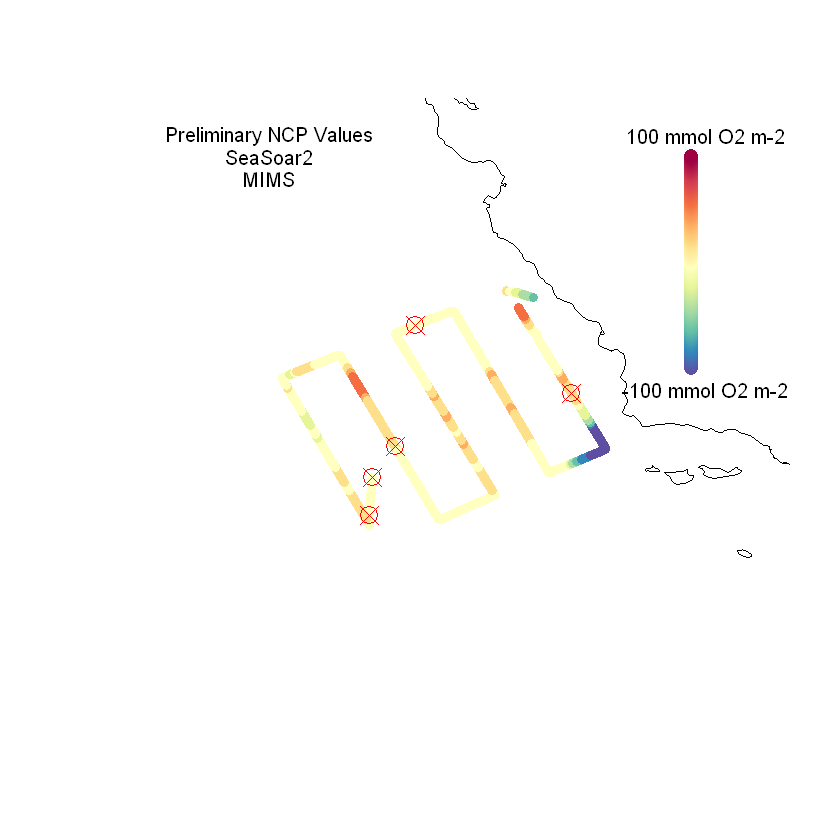

In [85]:
mark = as.POSIXct(x = "2017-06-06 12:00:00", tz = 'US/Pacific')
#plot.seasoar('SeaSoar2', 'MIMS', type = 'NCP', mark = mark)

In [87]:
## Net Community Production
pdf('Output/NCP Module - Spatial NCP All.pdf')

plot.seasoar('SeaSoar1', 'MIMS', type = 'NCP', mark = mark)
plot.seasoar('SeaSoar1', 'EIMS', type = 'NCP', mark = mark)
plot.seasoar('SeaSoar2', 'MIMS', type = 'NCP', mark = mark)
plot.seasoar('SeaSoar2', 'EIMS', type = 'NCP', mark = mark)

dev.off()

## Biological Oxygen Signal
pdf('Output/NCP Module - Spatial BOS ALL.pdf')

plot.seasoar('SeaSoar1', 'MIMS', type = 'BOS', mark = mark)
plot.seasoar('SeaSoar1', 'EIMS', type = 'BOS', mark = mark)
plot.seasoar('SeaSoar2', 'MIMS', type = 'BOS', mark = mark)
plot.seasoar('SeaSoar2', 'EIMS', type = 'BOS', mark = mark)

dev.off()

png 
  2

png 
  2

In [11]:
save(ship.data, file='./RStates/ship.ncp.2min.rdata')
#save(ship.data, file='./RStates/ship.ncp.30min.rdata')
#write.xlsx(ship.data, file='./Input Data/Shipdata - NCP.xlsx')

In [ ]:
for (i in unique(ship.data$Cycle)) {
    l = which(ship.data$Cycle == i)
    write.xlsx(ship.data[l,], file = paste0('Output/Ship.data Output - ', i, '.xlsx'))
}

In [2]:
load(file='./RStates/ship.ncp.2min.rdata')

# Cycles Analysis

In [119]:
plot.by.cycle = function (instrument = "MIMS", type = "NCP") {

    names = c("SeaSoar1", "SeaSoar2", "Cycle1", "Cycle2", "Cycle3", "Cycle4", "Transect1", "Transect2", "Transect3")
    
    for (i in names) {
        l = which(ship.data$Cycle == i)
        l.cycle.starts = c(which(ship.data$Cycle == "Cycle1")[1], which(ship.data$Cycle == "Cycle3")[1],
                           which(ship.data$Cycle == "Cycle2")[1], which(ship.data$Cycle == "Cycle4")[1])
        
        if (instrument == "MIMS") {
            flag = ship.data$MIMS.O2.Ar.FLAG[l]
            if (type == "NCP") {
                y = ship.data$NCP.MIMS[l]
                range = 100
            }
            else {
                y = ship.data$BOS.MIMS[l]
                range = 0.3
            }
        }
        else {
            flag = ship.data$EIMS.O2.Ar.FLAG[l]
            if (type == "NCP") {
                y = ship.data$NCP.EIMS[l]
                range = 100
            }
            else {
                y = ship.data$BOS.EIMS[l]
                range = 0.3
            }
        }
        
        col = make.div.pal2(y, 110, min = -range, max = range)
        flag.col = get.qual.pal(n = 4)
        
        plot(ship.data$DT[l], y, main = paste0(i, " - ", instrument), 
            pch = 16, cex = 0.8, lwd = 2, ylab = type, xlab = "", 
            col = flag.col[flag], ylim = c(-range * 1.1, range * 
                1.1))
        
        add.daynight("#00000004")
        
        mod = lowess(x = ship.data$DT[l], y, f = 0.05)
        lines(mod, col = "#ff000050", lwd = 2)
        lines(x = c(min(ship.data$DT), max(ship.data$DT)), y = c(0, 0), lty = 2)
        legend(ship.data$DT[l[1]], 0.3, c("Normal", "Interp 2", "Interp 1"), col = flag.col[1:3], cex = 0.7,
               lwd = 4, bg = "#00000010")
        
        ## Spatial Plot
        zoom = 0.25
        plot.map(ship.data$LO[l], ship.data$LA[l], col = col, zoom = zoom)
        points(x = rep(min(ship.data$LO[l]) - zoom, 101),
               y = seq(min(ship.data$LA[l]), max(ship.data$LA[l]), length.out = 101),
               col = get.div.pal(100), pch = 16, cex = 0.8)
        
        text(min(ship.data$LO[l]) - zoom + 0.08, max(ship.data$LA[l]), range, cex = 0.7)
        text(min(ship.data$LO[l]) - zoom + 0.08, min(ship.data$LA[l]) + 0.02, -range, cex = 0.7)
        points(ship.data$LO[l[1]], ship.data$LA[l[1]], col = "red", pch = 13, cex = 2)
        
        if (grepl("Trans", i)) {
            points(ship.data$LO[l.cycle.starts], ship.data$LA[l.cycle.starts], col = "red", pch = 10, cex = 2)
        }
    }
}

In [120]:
pdf('Output/NCP Module - BOS Cycles Preliminary MIMS.pdf')
par(mfrow=c(2,2))
plot.by.cycle('MIMS', 'BOS')
dev.off()

pdf('Output/NCP Module - NCP Cycles Preliminary MIMS.pdf')
par(mfrow=c(2,2))
plot.by.cycle('MIMS', 'NCP')
dev.off()

pdf('Output/NCP Module - BOS Cycles Preliminary EIMS.pdf')
par(mfrow=c(2,2))
plot.by.cycle('MIMS', 'BOS')
dev.off()

pdf('Output/NCP Module - NCP Cycles Preliminary EIMS.pdf')
par(mfrow=c(2,2))
plot.by.cycle('EIMS', 'NCP')
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

In [ ]:
#png('Output/NCP Module - Cycle Map.png')

col = get.qual.pal(length(unique(ship.data$Cycle)))
cols = sapply(ship.data$Cycle, function(x) {which(unique(ship.data$Cycle) == x)})

plot.map(ship.data$LO, ship.data$LA, col=col[cols], pch=16, cex = 0.6)
legend(-119, 37.5, c(unique(ship.data$Cycle)), col=col[unique(cols)], lwd=6, cex=0.7)

#dev.off()

In [27]:
pdf('Output/NCP - Smoothed EIMS NCP.pdf')

plot(ship.data$DT, runmed(ship.data$NCP.EIMS,381), pch=20, cex=0.3, ylim=c(-100,100))
#points(ship.data$DT, runmed(ship.data$NCP.MIMS,381), pch=20, cex=0.3, col='red')

dev.off()

png 
  2